# 0.1 - Setup

In [1]:
# Importing libraries

import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
# Configuring API key 

quandl.ApiConfig.api_key = 'z3pzAE7PpEar21-r5XyW'

# Q.2 - Find a data set to work and import it into your Jupyter notebook.

In [3]:
# Importing the business tendency and consumer opinion survey indicators dataset for Costa Rica.
# This data is a subset of the Main Economic Indicators (MEI) database.
# The Costa Rica data reports on a quarterly basis, so it shouldn't need any smoothing.

data = quandl.get('OECD/MEI_BTS_COS_BSEMFT_CRI_BLSA_Q')

In [4]:
data.head()

,Value
Date,
2010-06-30,13.961540
2010-09-30,8.000000
2010-12-31,6.818182
2011-03-31,11.111110
2011-06-30,13.698630


In [6]:
data.tail()

,Value
Date,
2020-12-31,-7.339449
2021-03-31,3.703704
2021-06-30,11.881190
2021-09-30,3.809524
2021-12-31,11.504430


In [8]:
data.shape

(47, 1)

In [9]:
data.columns

Index(['Value'], dtype='object')

In [10]:
type(data)

pandas.core.frame.DataFrame

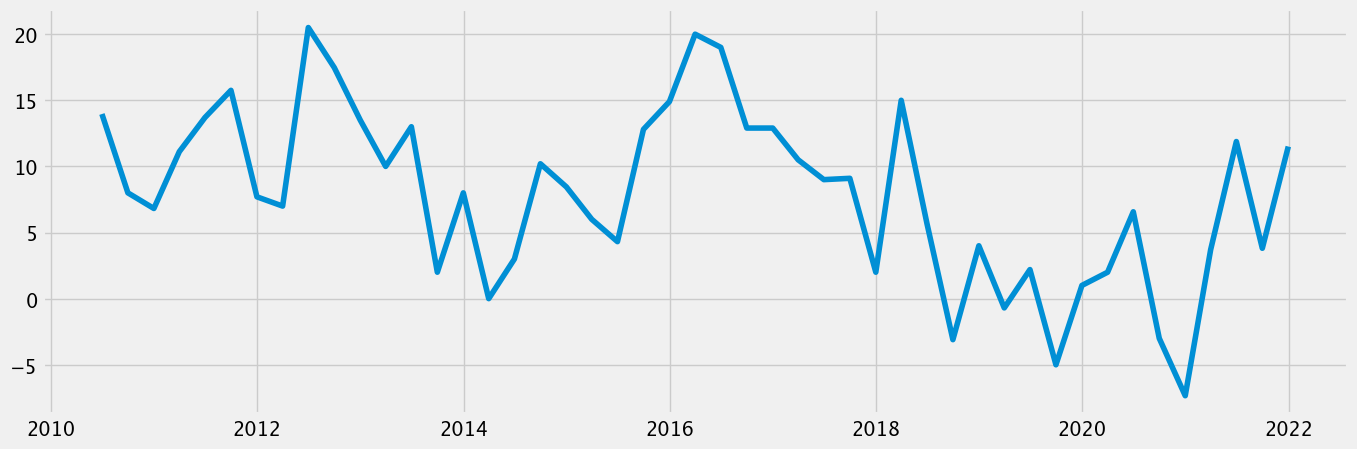

In [11]:
# Plotting the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)

plt.plot(data)

# Q.3 - Make a subset of your data set if necessary.

### This data was updated on Oct 20, 2021. So we just need to remove the Dec 21 value, as it is a forecast.

In [25]:
# Resetting index so we can remove the Dec 21 data.

data_2 = data.reset_index()

In [26]:
data_2.head()

,Date,Value
0,2010-06-30,13.961540
1,2010-09-30,8.000000
2,2010-12-31,6.818182
3,2011-03-31,11.111110
4,2011-06-30,13.698630


In [27]:
data_2.shape

(47, 2)

In [31]:
subset = data_2.drop(data_2[data_2['Date'] == '2021-12-31'].index)

In [32]:
subset.shape

(46, 2)

In [33]:
subset.head()

,Date,Value
0,2010-06-30,13.961540
1,2010-09-30,8.000000
2,2010-12-31,6.818182
3,2011-03-31,11.111110
4,2011-06-30,13.698630


In [34]:
subset.tail()

,Date,Value
41,2020-09-30,-3.000000
42,2020-12-31,-7.339449
43,2021-03-31,3.703704
44,2021-06-30,11.881190
45,2021-09-30,3.809524


In [35]:
# Setting the "Date" column as the index

from datetime import datetime

subset['datetime'] = pd.to_datetime(subset['Date']) 
subset = subset.set_index('datetime') 
subset.drop(['Date'], axis=1, inplace=True) 
subset.head()

,Value
datetime,
2010-06-30,13.961540
2010-09-30,8.000000
2010-12-31,6.818182
2011-03-31,11.111110
2011-06-30,13.698630


In [37]:
# Check for missing values

subset.isnull().sum() 

Value    0
dtype: int64

# Q.4 - Create a line chart of your data.

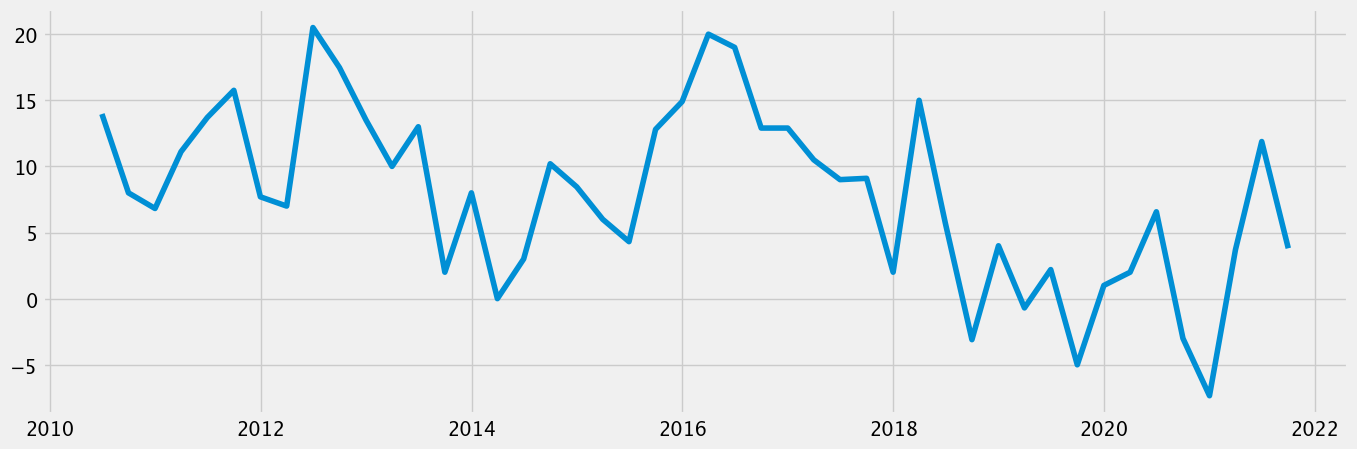

In [41]:
# Plotting the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(subset)

# Q.5 - Decompose the data’s components. 

In [46]:
# Decomposing the time series using an additive model
# The data doesn't appear very linear, but a multiplicative model won't work with negative values

decomposition = sm.tsa.seasonal_decompose(subset, model='additive')


In [47]:
from pylab import rcParams # Defining a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

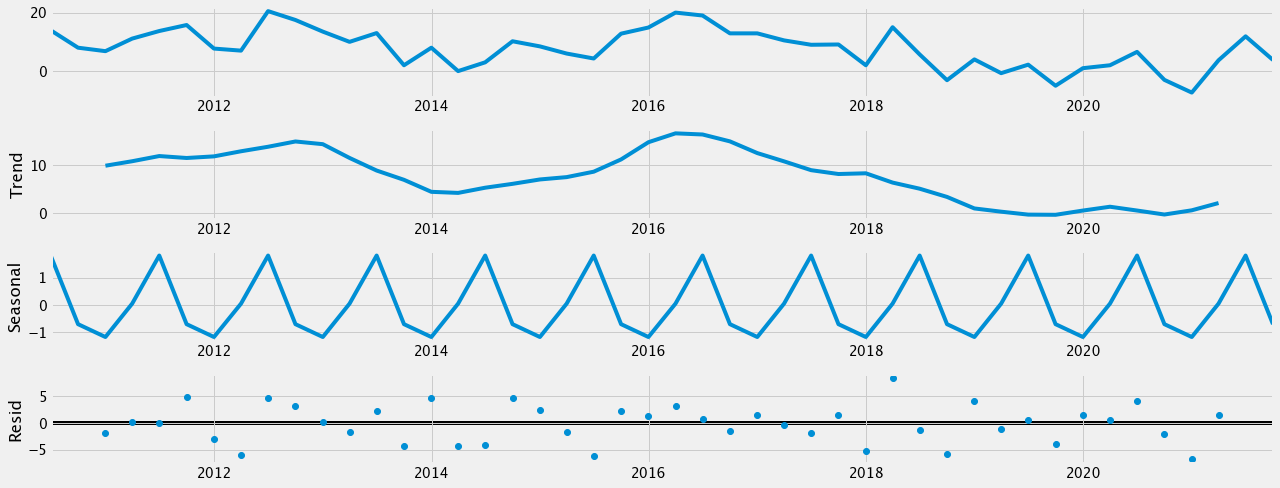

In [48]:
# Plotting the separate components

decomposition.plot()
plt.show()

### Trend: Our trend line demonstrates a long-term downward movement of roughly 8-9 points over 11 years.

### Seasonality: Interestingly, our data demonstrates a seasonality with peaks in June each year, and valleys in December.

### Noise: Our graph exposes fairly substantial, but erratic noise throughout the entire data set. This makes sense when we think about the fact that this is economic data with many, many contributing factors behind it.

# Q.6 - Conduct a Dickey-Fuller test to check for stationarity.

In [50]:
# Importing the adfuller() function

from statsmodels.tsa.stattools import adfuller 

# Defining the dickey-fuller funciton

def dickey_fuller(timeseries): 
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Appling the test using the function on the time series
dickey_fuller(subset['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -3.545954
p-value                         0.006882
Number of Lags Used             0.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64


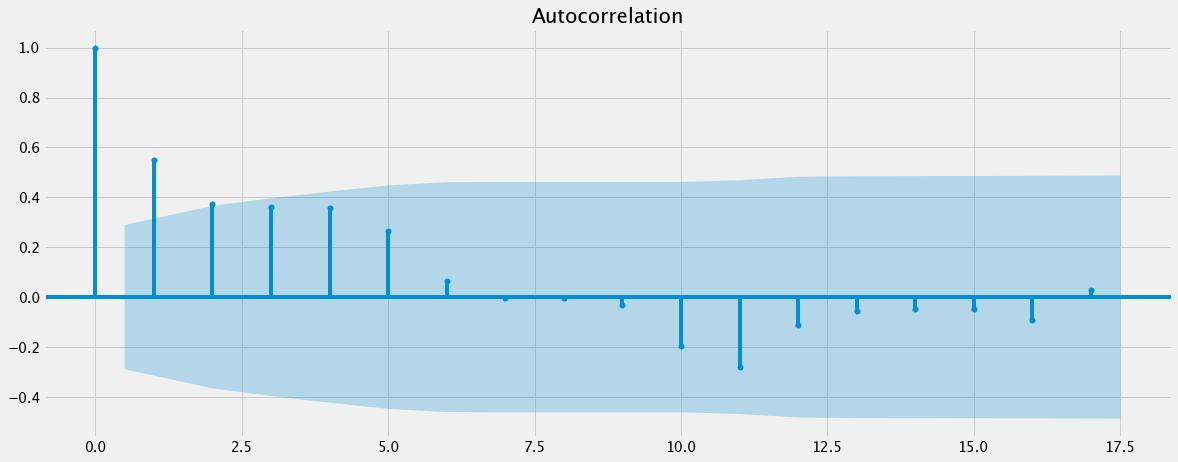

In [51]:
# Plotting for autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(subset)
plt.show()

### Our p-value (0.006882) is far less that 0.05. This means that our test result is significant.

### Our Test Statistic (-3.545954) is actually less than our Critical Values of 5% & 10%. This means that we can REJECT our null hypothesis (that there is a unit root present in the data) with a 95% degree of certainty. THERE IS NO UNIT ROOT. (I'm actually a bit surprised by that result.)

### Therefore, all jumps in the data are consistent with the variations in the data. The null hypothesis is disproven, and our data is stationary.

# Q.7 - If your data isn’t stationary, conduct a round of differencing on it and repeat step 6.

### For the sake of curiosity and practice, I'll conduct a round of differencing anyway.

In [52]:
# Creating a lag set

data_diff = subset - subset.shift(1) 

In [53]:
# Removing any missing values created during differencing
data_diff.dropna(inplace = True) 

In [54]:
data_diff.head()

,Value
datetime,
2010-09-30,-5.961540
2010-12-31,-1.181818
2011-03-31,4.292928
2011-06-30,2.587520
2011-09-30,2.054790


In [55]:
data_diff.columns

Index(['Value'], dtype='object')

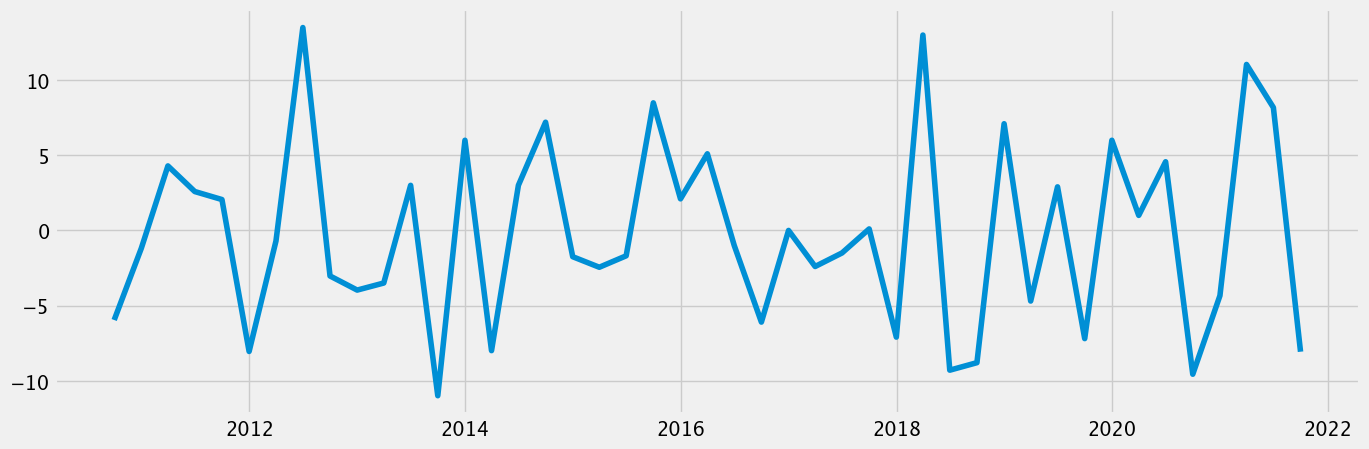

In [56]:
# Visualizing the result of the differencing on the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [57]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -7.009630e+00
p-value                        6.975894e-10
Number of Lags Used            1.000000e+00
Number of Observations Used    4.300000e+01
Critical Value (1%)           -3.592504e+00
Critical Value (5%)           -2.931550e+00
Critical Value (10%)          -2.604066e+00
dtype: float64


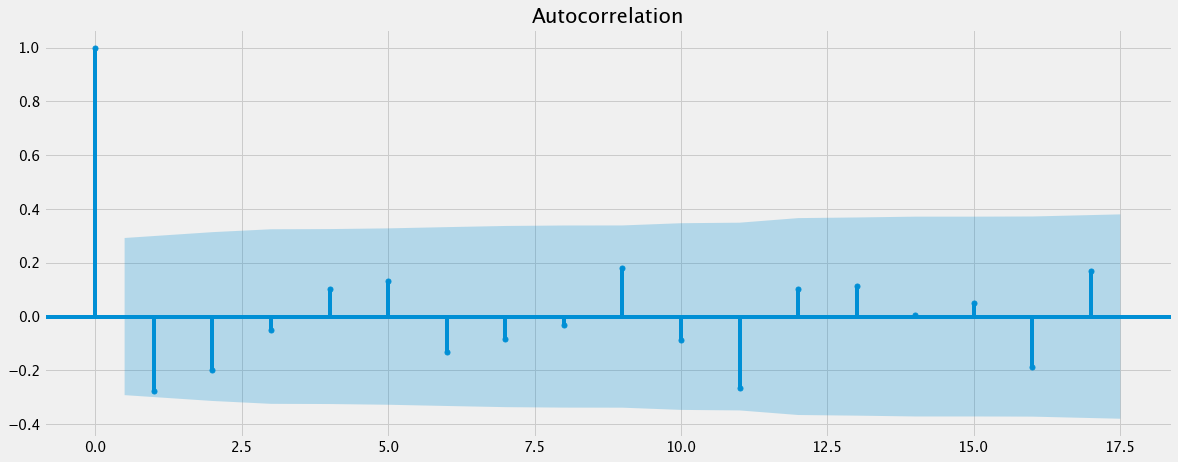

In [58]:
plot_acf(data_diff)
plt.show()